In [1]:
import numpy as np 
import pandas as pd 
from collections import Counter
import os
print(os.listdir("../input"))


['IDC_regular_ps50_idx5']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)


In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05)
len(tfms)

2

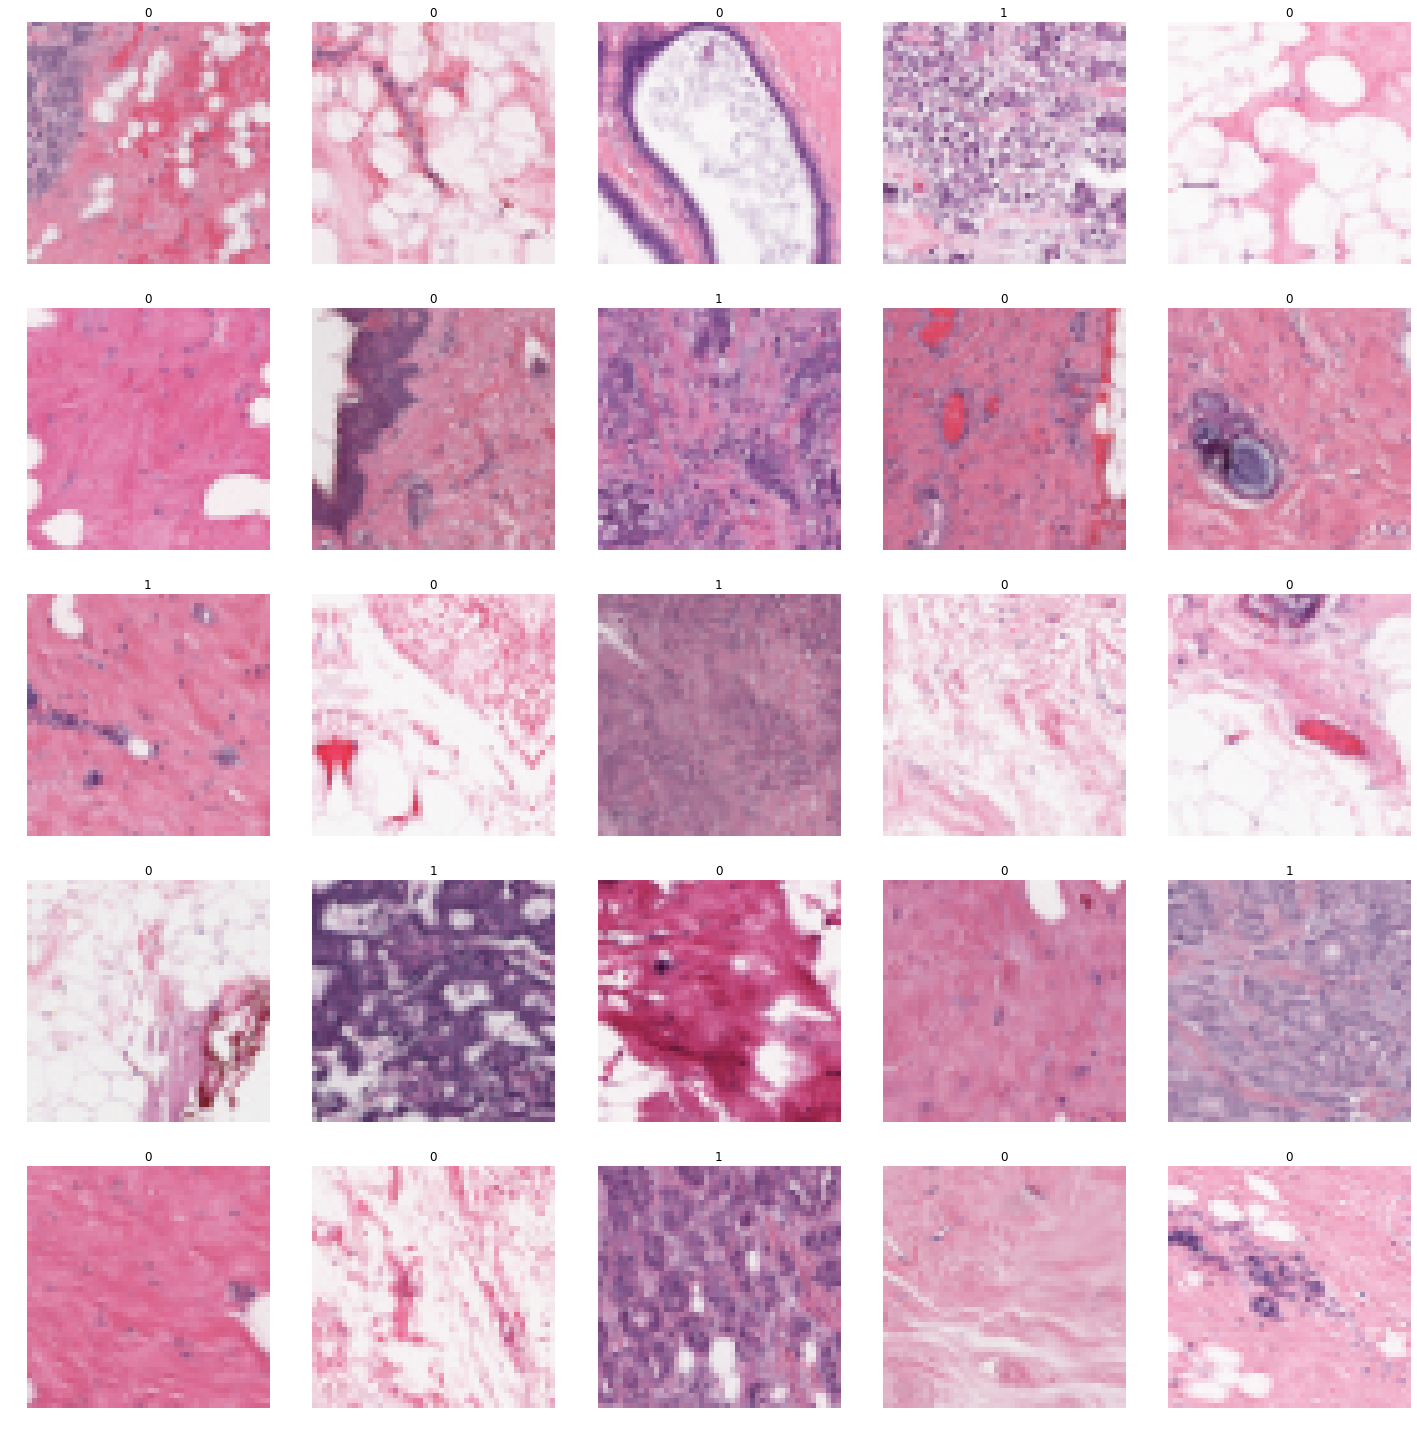

In [5]:
path = '../input/IDC_regular_ps50_idx5/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

data.show_batch()

0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer) 

IDC -> Invasive Ductal Carcinoma

## Distribution of the classes in the training and validation splits

In [6]:
train_counts = Counter(data.train_ds.y)
train_counts.most_common()

[(Category 0, 159089), (Category 1, 62931)]

In [7]:
valid_counts = Counter(data.valid_ds.y)
valid_counts.most_common()

[(Category 0, 39649), (Category 1, 15855)]

In [8]:
data.label_list

LabelLists;

Train: LabelList (222020 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,1,1,1,1
Path: ../input/IDC_regular_ps50_idx5;

Valid: LabelList (55504 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,1,0,0,0
Path: ../input/IDC_regular_ps50_idx5;

Test: None

## Looking at a few samples 

(Image (3, 48, 48), Category 1)


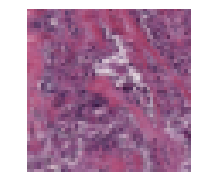

In [9]:
print(data.train_ds[5]);
show_image(data.train_ds[5][0],)

(Image (3, 48, 48), Category 0)


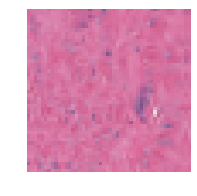

In [10]:
print(data.train_ds[45]);
show_image(data.train_ds[45][0])

(Image (3, 48, 48), Category 0)


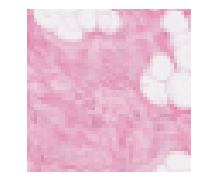

In [11]:
print(data.valid_ds[45]);
show_image(data.valid_ds[45][0])

(Image (3, 48, 48), Category 0)


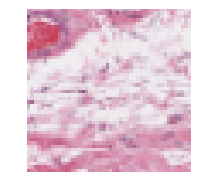

In [12]:
print(data.valid_ds[53]);
show_image(data.valid_ds[53][0])

(Image (3, 48, 48), Category 0)


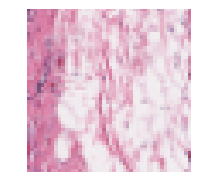

In [13]:
print(data.valid_ds[598]);
show_image(data.valid_ds[598][0])

In [14]:
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 28405203.98it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


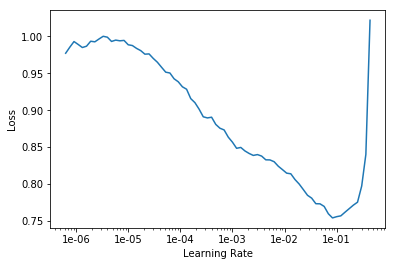

In [15]:
# Begin the training
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/tmp/models')
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,accuracy,time
0,0.450705,0.370981,0.839651,09:20
1,0.361862,0.327632,0.860983,06:42
2,0.329513,0.316251,0.852533,06:38
3,0.317058,0.303232,0.870784,06:35
4,0.312880,0.301662,0.869235,06:38


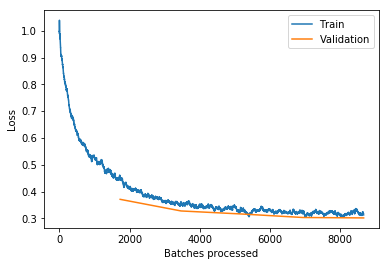

In [16]:
learn.fit_one_cycle(5, max_lr=slice(1e-03, 1e-04));
learn.recorder.plot_losses()

In [23]:
!ls ../input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x751_y251_class1.png

../input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x751_y251_class1.png


In [17]:
layers = flatten_model(learn.model)

In [18]:
from fastai.callbacks import hook_outputs
custom_hook = hook_outputs(layers)

In [19]:
learn.model.eval();

In [24]:
img = open_image('../input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x751_y251_class1.png')
learn.predict(img)

(Category 1, tensor(1), tensor([0.0799, 0.9201]))

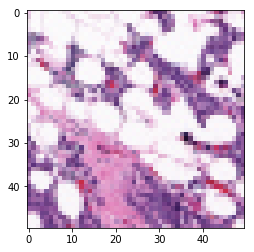

In [26]:
plt.imshow(plt.imread('../input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x751_y251_class1.png'))

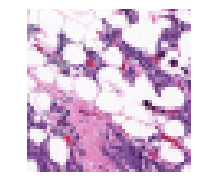

In [32]:
show_image(open_image('../input/IDC_regular_ps50_idx5/10253/1/10253_idx5_x751_y251_class1.png'))

In [27]:
cmap = 'inferno'
stored_hooks_rank = [len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))]
min_rank = min([len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))])
first_flat_layer = stored_hooks_rank.index(min_rank); first_flat_layer

126

In [30]:
def show_2D_act(hook ,l=0, nrows=3, ncols=9, s=12):
    '''Show nrows*ncols activation visualizations of the l-th layer with figsize s*s'''
    fig, axes = plt.subplots(nrows, ncols, figsize=(s,s/3))
    fig.subplots_adjust(hspace=0.1, wspace=0, left=0, right=1, top=1, bottom=0)
    for i, ax in enumerate(axes.flat):
        ax.imshow(custom_hook.stored[l][0][i].cpu())
        ax.set_axis_off()

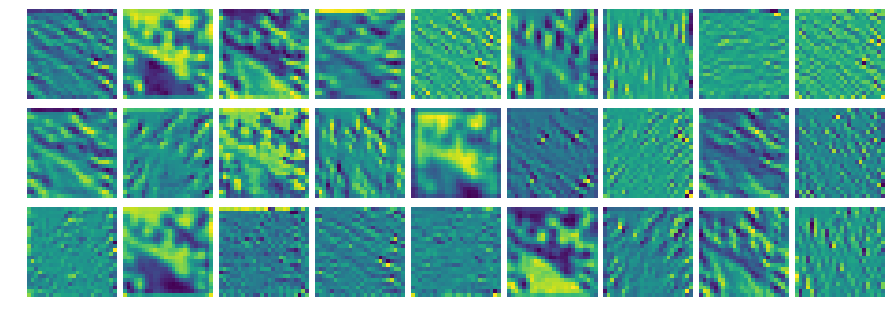

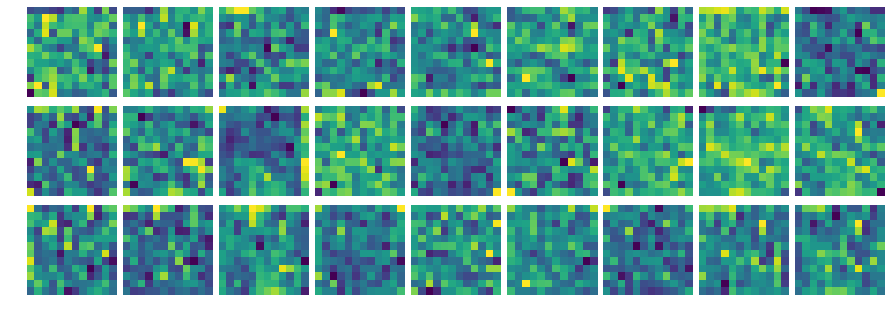

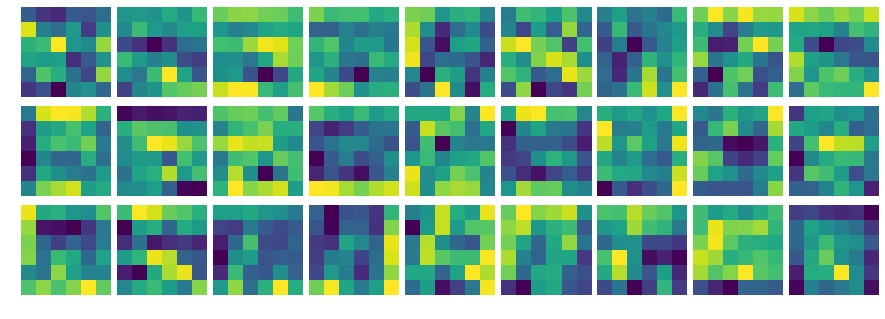

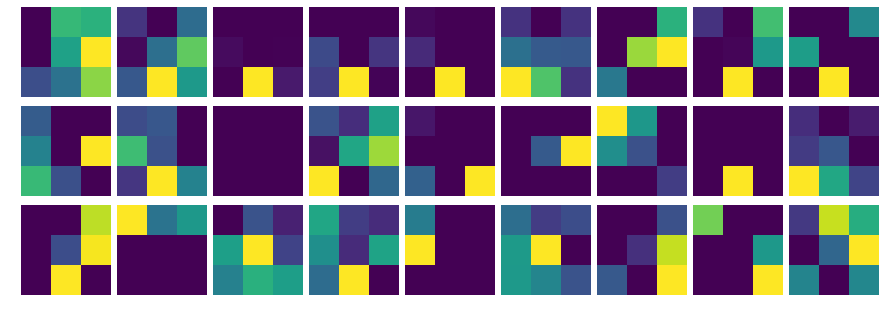

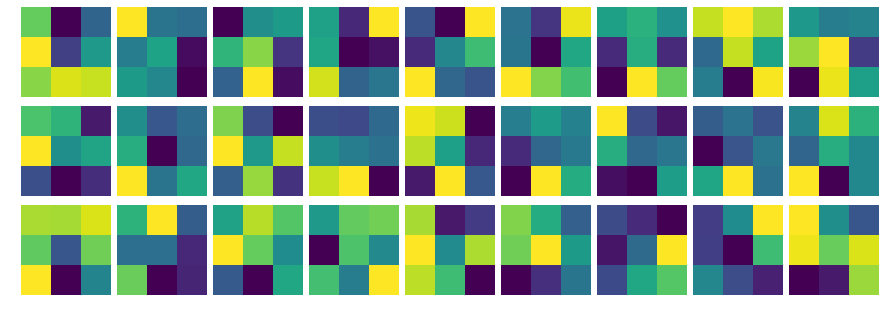

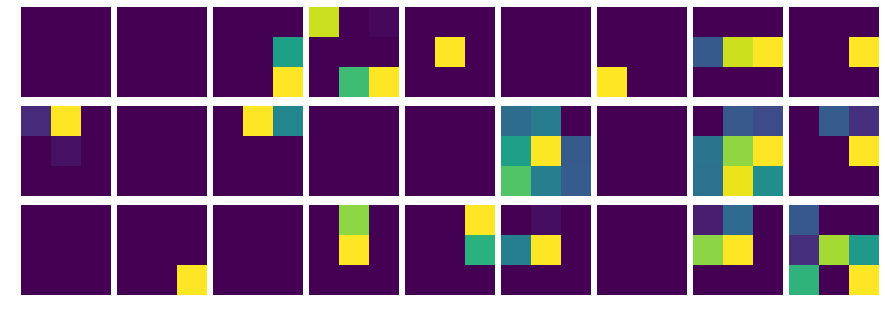

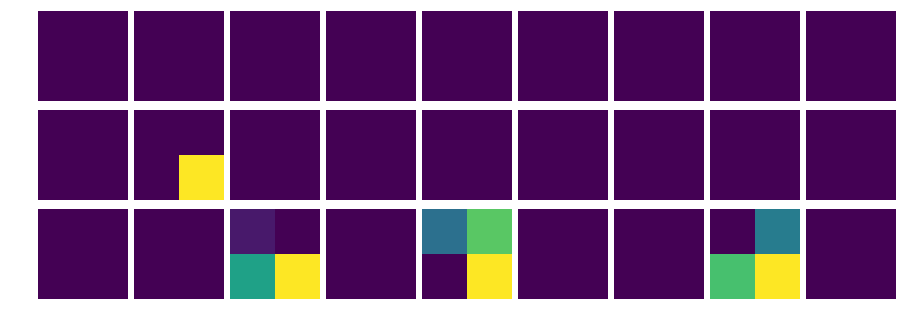

In [31]:
for i in range(0,first_flat_layer,20):
    #print('Layer#:',i) # Does not work? Will fix later.
    show_2D_act(custom_hook, i)